In [1]:
# parameters
config_dir = "../experiments"
exp_name = "075_cloud_water_feat/002_all"  # "072_save_input_valid/base_all_save

In [2]:
%cd /kaggle/working

from pathlib import Path

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(
    version_base=None, config_path=f"{config_dir}/{exp_name.split('/')[0]}"
):
    cfg = compose(
        config_name="config.yaml",
        overrides=[f"exp={exp_name.split('/')[-1]}"],
        return_hydra_config=True,
    )
import pickle

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

from utils.metric import score

# 定数定義
output_dir = Path(f"output/experiments/{exp_name}")
gcs_path = f"gs://{cfg.dir.gcs_bucket}/{cfg.dir.gcs_base_dir}/experiments/{exp_name}/"

# カラムの定義
single_targets = [
    "cam_out_NETSW",
    "cam_out_FLWDS",
    "cam_out_PRECSC",
    "cam_out_PRECC",
    "cam_out_SOLS",
    "cam_out_SOLL",
    "cam_out_SOLSD",
    "cam_out_SOLLD",
]
seq_targets = [
    "ptend_t",
    "ptend_q0001",
    "ptend_q0002",
    "ptend_q0003",
    "ptend_u",
    "ptend_v",
]
target_columns = []
for col in seq_targets:
    for i in range(60):
        target_columns.append(f"{col}_{i}")
target_columns.extend(single_targets)


# 結果などの読み込み
r2_score_dict = pickle.load(open(output_dir / "r2_score_dict.pkl", "rb"))
r2_score_dict_fill = pickle.load(open(output_dir / "r2_score_dict_fill.pkl", "rb"))

/kaggle/working


In [3]:
import numpy as np
import pandas as pd

In [4]:
ss_df = pl.read_csv(
    "input/leap-atmospheric-physics-ai-climsim/sample_submission.csv", n_rows=1
)
weight_array = ss_df.select([x for x in ss_df.columns if x != "sample_id"]).to_numpy()[
    0
]

In [5]:
n_rows = None

In [6]:
print("read original_xs")
original_xs_df = pl.read_parquet(
    gcs_path + "original_xs.parquet", retries=5, n_rows=n_rows
)

read original_xs


In [7]:
print("read predict")
predict_df = pl.read_parquet(gcs_path + "predict.parquet", retries=5, n_rows=n_rows)
print("read label")
label_df = pl.read_parquet(gcs_path + "label.parquet", retries=5, n_rows=n_rows)

read predict
read label


In [8]:
preds = predict_df[:, 1:].to_numpy()
original_xs = original_xs_df[:, 1:].to_numpy()

for col in cfg.exp.fill_target:
    col_index = cfg.cols.col_names.index(col)
    preds[:, col_index] = original_xs[:, col_index] / (-1200)

In [9]:
# 普通に計算
predict_weight_df = pd.DataFrame(
    preds * weight_array,
    columns=[i for i in range(preds.shape[1])],
).reset_index()
label_weight_df = pd.DataFrame(
    label_df[:, 1:].to_numpy() * weight_array,
    columns=[i for i in range(preds.shape[1])],
).reset_index()

r2_scores = score(
    label_weight_df,
    predict_weight_df,
    "index",
    multioutput="raw_values",
)

r2_score_dict_const = {
    col: r2 for col, r2 in dict(zip(cfg.cols.col_names, r2_scores)).items()
}
print("r2: ", np.mean(list(r2_score_dict_const.values())))

r2:  0.7396488374146083


In [10]:
r2_score_dict_const

{'ptend_t_0': 0.7754999293284202,
 'ptend_t_1': 0.5326199735615816,
 'ptend_t_2': 0.8847368611398397,
 'ptend_t_3': 0.8903321874015013,
 'ptend_t_4': 0.9533699765876648,
 'ptend_t_5': 0.981141486856548,
 'ptend_t_6': 0.9845333526230757,
 'ptend_t_7': 0.9841478644475483,
 'ptend_t_8': 0.9928567792667912,
 'ptend_t_9': 0.9929861899584648,
 'ptend_t_10': 0.9926483038295077,
 'ptend_t_11': 0.9925595644258878,
 'ptend_t_12': 0.9914384326740106,
 'ptend_t_13': 0.990462973713199,
 'ptend_t_14': 0.9881796500471451,
 'ptend_t_15': 0.9835172883704904,
 'ptend_t_16': 0.9365414600917537,
 'ptend_t_17': 0.6768255432663436,
 'ptend_t_18': 0.49298447299500614,
 'ptend_t_19': 0.4689328199062398,
 'ptend_t_20': 0.5190687276921322,
 'ptend_t_21': 0.5577092182748069,
 'ptend_t_22': 0.618264441989617,
 'ptend_t_23': 0.6641483642861896,
 'ptend_t_24': 0.7215651177932854,
 'ptend_t_25': 0.773278497402003,
 'ptend_t_26': 0.8180228742318532,
 'ptend_t_27': 0.8556901912843278,
 'ptend_t_28': 0.877494983832675,

In [11]:
tmelt_array = np.load(
    "output/preprocess/tmelt_tice_001/001/tmelt_array.npy", allow_pickle=True
)
tice_array = np.load(
    "output/preprocess/tmelt_tice_001/001/tice_array.npy", allow_pickle=True
)

In [12]:
# tmelt以上の値を置き換える

tmelt_cond = original_xs[:, :60] > tmelt_array
preds[:, 180:240] = np.where(
    tmelt_cond, original_xs[:, 180:240] / (-1200), preds[:, 180:240]
)

In [13]:
predict_weight_df = pd.DataFrame(
    preds * weight_array,
    columns=[i for i in range(preds.shape[1])],
).reset_index()
label_weight_df = pd.DataFrame(
    label_df[:, 1:].to_numpy() * weight_array,
    columns=[i for i in range(preds.shape[1])],
).reset_index()

r2_scores = score(
    label_weight_df,
    predict_weight_df,
    "index",
    multioutput="raw_values",
)

r2_score_dict_const = {
    col: r2 for col, r2 in dict(zip(cfg.cols.col_names, r2_scores)).items()
}
print("r2: ", np.mean(list(r2_score_dict_const.values())))

r2:  0.7396677185514166


In [14]:
# tice以下の値を置き換える

tmelt_cond = original_xs[:, :60] < tice_array
preds[:, 120:180] = np.where(
    tmelt_cond, original_xs[:, 120:180] / (-1200), preds[:, 120:180]
)

In [15]:
predict_weight_df = pd.DataFrame(
    preds * weight_array,
    columns=[i for i in range(preds.shape[1])],
).reset_index()
label_weight_df = pd.DataFrame(
    label_df[:, 1:].to_numpy() * weight_array,
    columns=[i for i in range(preds.shape[1])],
).reset_index()

r2_scores = score(
    label_weight_df,
    predict_weight_df,
    "index",
    multioutput="raw_values",
)

r2_score_dict_const = {
    col: r2 for col, r2 in dict(zip(cfg.cols.col_names, r2_scores)).items()
}
print("r2: ", np.mean(list(r2_score_dict_const.values())))

r2:  0.7396792162243201


In [85]:
r2_score_dict_const

{'ptend_t_0': 0.5763062111744768,
 'ptend_t_1': -0.1942271115946559,
 'ptend_t_2': 0.8377200558538942,
 'ptend_t_3': 0.9564898176418639,
 'ptend_t_4': 0.9941961230440278,
 'ptend_t_5': 0.994435252033148,
 'ptend_t_6': 0.996483449690632,
 'ptend_t_7': 0.994312426601684,
 'ptend_t_8': 0.9919366576312794,
 'ptend_t_9': 0.9880280563909923,
 'ptend_t_10': 0.9873227545273765,
 'ptend_t_11': 0.9868972942767615,
 'ptend_t_12': 0.9875725896058379,
 'ptend_t_13': 0.9870330834164053,
 'ptend_t_14': 0.9860064235308668,
 'ptend_t_15': 0.9798392614147124,
 'ptend_t_16': 0.9228515847219104,
 'ptend_t_17': 0.34778218874653866,
 'ptend_t_18': -0.18156512906913447,
 'ptend_t_19': -0.3767044664855079,
 'ptend_t_20': -0.0640437693561311,
 'ptend_t_21': 0.05434757413682845,
 'ptend_t_22': 0.2962256207817229,
 'ptend_t_23': 0.43996569811092434,
 'ptend_t_24': 0.5689032911740803,
 'ptend_t_25': 0.6799705801080488,
 'ptend_t_26': 0.7647266177993556,
 'ptend_t_27': 0.8222290591010327,
 'ptend_t_28': 0.85219000

## 全体概要

In [22]:
print("r2: ", np.mean(list(r2_score_dict.values())))
print("r2 fill: ", np.mean(list(r2_score_dict_fill.values())))

r2:  -3.337288825984124
r2 fill:  -3.3370633697818888


## sequential target

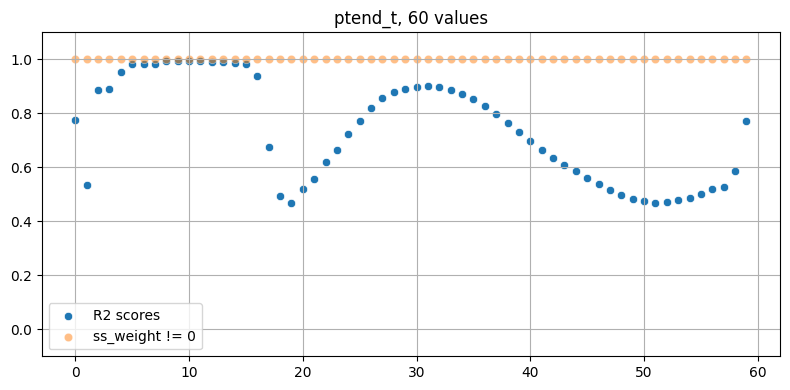

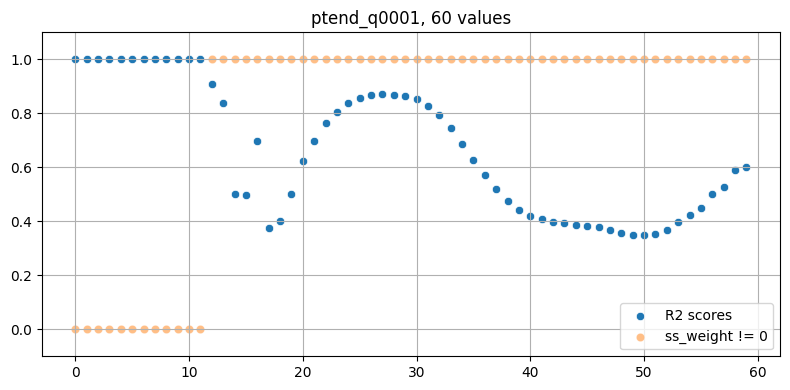

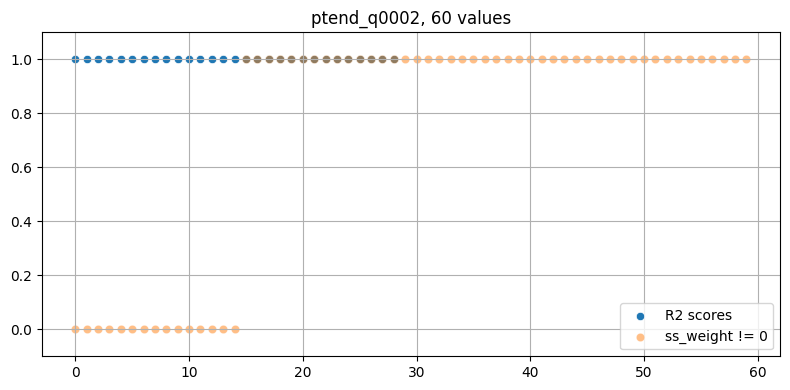

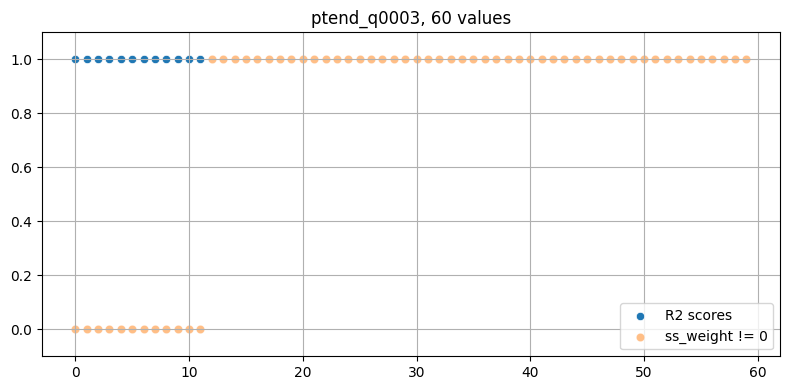

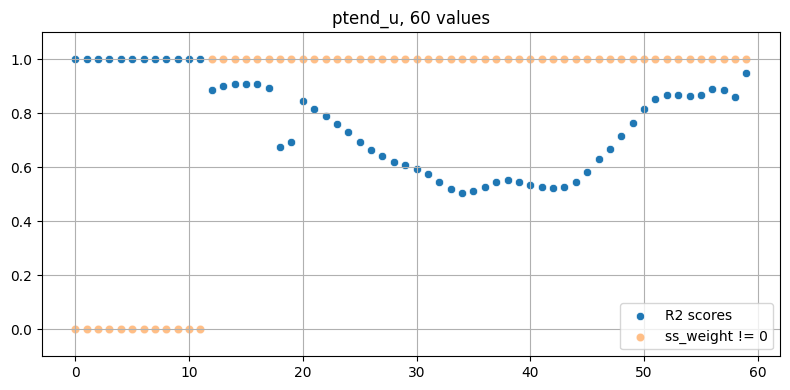

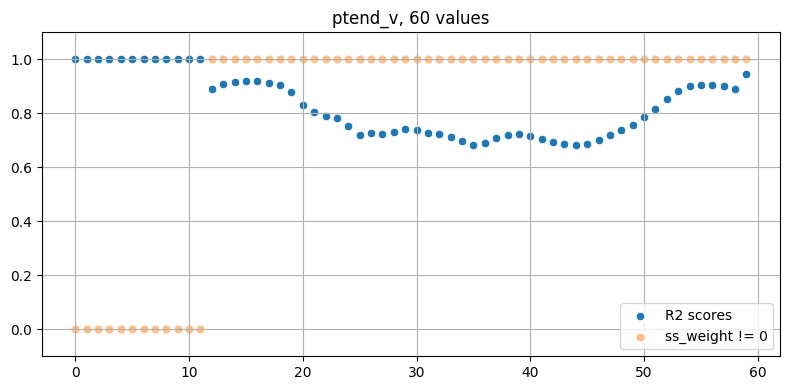

In [10]:
for col in seq_targets:
    fig, ax = plt.subplots(figsize=(8, 4))

    sns.scatterplot(
        x=range(60),
        y=[r2_score_dict_fill[f"{col}_{i}"] for i in range(60)],
        label="R2 scores",
        ax=ax,
    )
    sns.scatterplot(
        x=range(60),
        y=[(ss_df[f"{col}_{i}"].to_numpy()[0] != 0) for i in range(60)],
        alpha=0.5,
        label="ss_weight != 0",
        ax=ax,
    )

    ax.set_title(f"{col}, 60 values")
    ax.grid(True)
    ax.set_ylim(-0.1, 1.1)
    ax.legend()

    plt.tight_layout()
    plt.show()

## single target

cam_out_NETSW : 0.9718121598781626
cam_out_FLWDS : 0.9842585893538656
cam_out_PRECSC : 0.8998982284314702
cam_out_PRECC : 0.890094181829523
cam_out_SOLS : 0.9656921096029863
cam_out_SOLL : 0.9563017526129842
cam_out_SOLSD : 0.9445069529982127
cam_out_SOLLD : 0.879892121916505


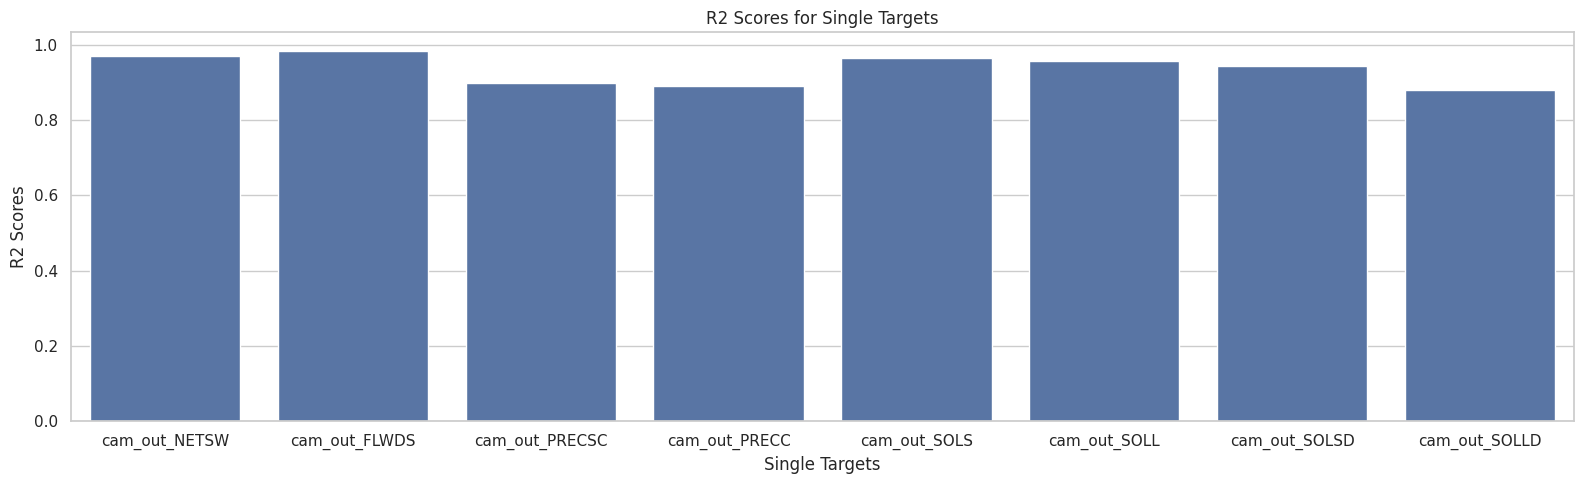

In [11]:
# single scaler target
plt.figure(figsize=(16, 5))
sns.set(style="whitegrid")

sns.barplot(
    x=np.array(single_targets),
    y=np.array([r2_score_dict[col] for col in single_targets]),
)

plt.xlabel("Single Targets")
plt.ylabel("R2 Scores")
plt.title("R2 Scores for Single Targets")

for col in single_targets:
    print(f"{col} : {r2_score_dict[col]}")

plt.tight_layout()
plt.show()

## マイナスが大きいターゲットについて確認

In [6]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / f"y_nanmean_{cfg.exp.norm_name}.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / f"y_rms_sub_{cfg.exp.norm_name}.npy")
y_lower_bound = np.load(
    Path(cfg.exp.scale_dir) / f"y_lower_bound_{cfg.exp.norm_name}.npy"
)
y_upper_bound = np.load(
    Path(cfg.exp.scale_dir) / f"y_upper_bound_{cfg.exp.norm_name}.npy"
)


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.01:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(
        f"{y_rms_sub[ci]=:.5g}, {y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}"
    )
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].min()=:.5g}, {labels[:,ci].max()=:.5g}"
    )
    print()

【 ptend_t_0 】
r2_score=-0.292
ri=379, ci=0
preds[ri,ci]=-2.4652e-06, labels[ri,ci]=5.9823e-05
mse[ri]=3.8798e-09, r2: 1-(mse.mean()=9.1867e-10)/(base.mean()=7.1104e-10)
y_rms_sub[ci]=3.0425e-05, y_nanmean[ci]=1.0277e-05, y_lower_bound[ci]=-0.0011344, y_upper_bound[ci]=0.0021631
preds[:,ci].mean()=-2.5419e-06, preds[:,ci].min()=-2.6243e-06, preds[:,ci].max()=-2.4408e-06
labels[:,ci].mean()=1.1865e-05, labels[:,ci].min()=-4.3717e-05, labels[:,ci].max()=5.9823e-05

【 ptend_t_1 】
r2_score=-0.00079644
ri=353, ci=1
preds[ri,ci]=-1.0063e-05, labels[ri,ci]=-0.00013155
mse[ri]=1.4759e-08, r2: 1-(mse.mean()=1.8604e-09)/(base.mean()=1.8589e-09)
y_rms_sub[ci]=4.1836e-05, y_nanmean[ci]=-7.0465e-06, y_lower_bound[ci]=-0.0011881, y_upper_bound[ci]=0.0016273
preds[:,ci].mean()=-9.7376e-06, preds[:,ci].min()=-1.013e-05, preds[:,ci].max()=-9.4282e-06
labels[:,ci].mean()=-1.1286e-05, labels[:,ci].min()=-0.00013155, labels[:,ci].max()=7.682e-05

【 ptend_t_2 】
r2_score=-0.096498
ri=721, ci=2
preds[ri,ci]=-

## 値が大きくないやつ

In [7]:
preds = predict_df[:, 1:].to_numpy()
labels = label_df[:, 1:].to_numpy()

scale_dir = ""
y_nanmean = np.load(Path(cfg.exp.scale_dir) / f"y_nanmean_{cfg.exp.norm_name}.npy")
y_rms_sub = np.load(Path(cfg.exp.scale_dir) / f"y_rms_sub_{cfg.exp.norm_name}.npy")
y_lower_bound = np.load(
    Path(cfg.exp.scale_dir) / f"y_lower_bound_{cfg.exp.norm_name}.npy"
)
y_upper_bound = np.load(
    Path(cfg.exp.scale_dir) / f"y_upper_bound_{cfg.exp.norm_name}.npy"
)


for ci, col in enumerate(target_columns):
    r2_score = r2_score_dict[col]
    if r2_score > 0.5:
        continue

    print("【", col, "】")
    print(f"{r2_score=:.5g}")

    mse = (preds[:, ci] - labels[:, ci]) ** 2
    base = (labels[:, ci] - labels[:, ci].mean()) ** 2
    ri = np.nonzero(mse == np.max(mse))[0][0]
    print(f"{ri=}, {ci=}")
    print(f"{preds[ri,ci]=:.5g}, {labels[ri,ci]=:.5g}")
    print(f"{mse[ri]=:.5g}, r2: 1-({mse.mean()=:.5g})/({base.mean()=:.5g})")

    print(
        f"{y_rms_sub[ci]=:.5g}, {y_nanmean[ci]=:.5g}, {y_lower_bound[ci]=:.5g}, {y_upper_bound[ci]=:.5g}"
    )
    print(
        f"{preds[:,ci].mean()=:.5g}, {preds[:,ci].min()=:.5g}, {preds[:,ci].max()=:.5g}"
    )
    print(
        f"{labels[:,ci].mean()=:.5g}, {labels[:,ci].min()=:.5g}, {labels[:,ci].max()=:.5g}"
    )
    print()

【 ptend_t_0 】
r2_score=-0.292
ri=379, ci=0
preds[ri,ci]=-2.4652e-06, labels[ri,ci]=5.9823e-05
mse[ri]=3.8798e-09, r2: 1-(mse.mean()=9.1867e-10)/(base.mean()=7.1104e-10)
y_rms_sub[ci]=3.0425e-05, y_nanmean[ci]=1.0277e-05, y_lower_bound[ci]=-0.0011344, y_upper_bound[ci]=0.0021631
preds[:,ci].mean()=-2.5419e-06, preds[:,ci].min()=-2.6243e-06, preds[:,ci].max()=-2.4408e-06
labels[:,ci].mean()=1.1865e-05, labels[:,ci].min()=-4.3717e-05, labels[:,ci].max()=5.9823e-05

【 ptend_t_1 】
r2_score=-0.00079644
ri=353, ci=1
preds[ri,ci]=-1.0063e-05, labels[ri,ci]=-0.00013155
mse[ri]=1.4759e-08, r2: 1-(mse.mean()=1.8604e-09)/(base.mean()=1.8589e-09)
y_rms_sub[ci]=4.1836e-05, y_nanmean[ci]=-7.0465e-06, y_lower_bound[ci]=-0.0011881, y_upper_bound[ci]=0.0016273
preds[:,ci].mean()=-9.7376e-06, preds[:,ci].min()=-1.013e-05, preds[:,ci].max()=-9.4282e-06
labels[:,ci].mean()=-1.1286e-05, labels[:,ci].min()=-0.00013155, labels[:,ci].max()=7.682e-05

【 ptend_t_2 】
r2_score=-0.096498
ri=721, ci=2
preds[ri,ci]=-